In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from analysis.plot_matplotlib import plot_hist
from analysis.mc import BinnedImportanceSamplingIntegrator
from analysis.mc import ImportanceSamplingIntegrator
from analysis import tnp, tnp_mode
from analysis.utils import module_reload
import pandas as pd

#tnp_mode(1);

# NF example

In [80]:
# Physics
#from analysis.cffi.mg5.lib import mc_batch, mc_batch_sigma
from analysis.import_data import import_true_reco
from analysis.nis.distributions import HyperUniform
import normflows as nf
from normflows.distributions import BaseDistribution
from typing import Optional, Callable
import numpy as np
import pandas as pd
import torch

In [117]:
from normflows.flows import Flow

class ScaleShift(Flow):
    def __init__(self, scale:torch.Tensor, shift:torch.Tensor):
        super().__init__()
        
        self.scale = scale
        self.shift = shift
    
    def forward(self, z, context=None):
        z = z * self.scale + self.shift
        log_det = torch.zeros(len(z), device=z.device)
        
        return z, log_det

    def inverse(self, z, context=None):
        z = z - self.shift
        z = z/self.scale
        log_det = torch.zeros(len(z), device=z.device)
        
        return z, log_det

In [123]:
def print_model_summary(model):
    print(
        'Model: %s\nParameters: %i' %
        (model, sum(p.numel() for p in model.parameters()))
    )

def get_nfm(q0:BaseDistribution,
            K:int = 16,
            latent_size:int = 2,
            hidden_units: int = 256,
            hidden_layers:int = 2,
            cuda_if_available:bool = True,
            flow:Callable = nf.flows.CoupledRationalQuadraticSpline,#nf.flows.AutoregressiveRationalQuadraticSpline,
            linear_permute:bool=False,
            random_permute:bool=True,
            flow_args:dict = { 'num_bins': 16, 'tails': None, 'init_identity': True },
            seed:Optional[int]=None):
    
    if seed is not None:
        torch.manual_seed(seed)
        
    device = 'cpu'# torch.device('cuda' if torch.cuda.is_available() and cuda_if_available else 'cpu')

    flows = []
    for i in range(K):
        flows += [flow(latent_size, hidden_layers, hidden_units, **flow_args)]
        if linear_permute:
            flows += [nf.flows.LULinearPermute(latent_size)]
        if random_permute:
            flows += [nf.flows.Permute(latent_size)]

    # Set base distribuiton
    if isinstance(q0, HyperUniform):
        scale = q0.high - q0.low
        shift = q0.high - q0.low - .5*torch.ones(latent_size)
        flows += [ScaleShift(scale=scale, shift=shift)]
        
    # Construct flow model
    nfm = nf.NormalizingFlow(q0=q0, flows=flows)

    print("Using device " + f"GPU ({torch.cuda.get_device_name(0)})" if torch.cuda.is_available() else "CPU")
    print(f"Model with {sum(p.numel() for p in nfm.parameters())} parameters")
    
    # Move model on GPU if available
    return nfm.to(device)

(array([[24., 17., 23., ..., 30., 26., 25.],
        [17., 29., 29., ..., 22., 30., 24.],
        [22., 23., 26., ..., 21., 27., 23.],
        ...,
        [18., 23., 13., ..., 26., 25., 23.],
        [26., 26., 23., ..., 36., 20., 22.],
        [32., 20., 24., ..., 25., 27., 28.]]),
 array([-1.99999952e+00, -1.93750013e+00, -1.87500073e+00, -1.81250133e+00,
        -1.75000194e+00, -1.68750254e+00, -1.62500314e+00, -1.56250375e+00,
        -1.50000435e+00, -1.43750495e+00, -1.37500556e+00, -1.31250616e+00,
        -1.25000677e+00, -1.18750737e+00, -1.12500797e+00, -1.06250858e+00,
        -1.00000918e+00, -9.37509783e-01, -8.75010386e-01, -8.12510990e-01,
        -7.50011593e-01, -6.87512197e-01, -6.25012800e-01, -5.62513404e-01,
        -5.00014007e-01, -4.37514611e-01, -3.75015214e-01, -3.12515818e-01,
        -2.50016421e-01, -1.87517025e-01, -1.25017628e-01, -6.25182316e-02,
        -1.88350677e-05,  6.24805614e-02,  1.24979958e-01,  1.87479354e-01,
         2.49978751e-01,  3.124

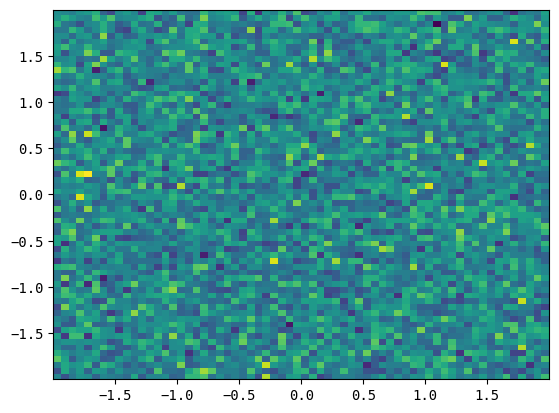

In [130]:
a = HyperUniform(low=[-2., -2.], high=[2., 2.])
#a = nf.distributions.base.Uniform(2, low=0., high=1.)
#a = nf.distributions.base.DiagGaussian(2, trainable=False)

z = a.sample(100000)

pX = z.T[0].detach().cpu().numpy()
pY = z.T[1].detach().cpu().numpy()

plt.hist2d(pX, pY, bins=(64,64))

In [131]:
def plot_proposal(nfm, n_samples:int=1024):
    is_nfm = isinstance(nfm, nf.NormalizingFlow)
    
    if is_nfm:
        samples = nfm.sample(n_samples)[0]
    else:
        samples = nfm.sample(n_samples)
        
    samples = samples.detach().cpu().numpy()

    all_max = np.max(samples).max()
    all_min = np.min(samples).min()
    print(f'Using inferred bounds {all_min} to {all_max}')
    #print((all_min, all_max))

    plot_hist(pd.DataFrame(dict(x=samples.T[0], y=samples.T[1])), normalize=True, xlim=(all_min, all_max), xlim_binning=(all_min, all_max))
    if False:
        fig, ax = plt.subplots()
        ax.set_title("q0")
        for i in range(len(samples.T)):
            ax.hist(samples.T[i], alpha=0.4, label=f"Dim {i}",
                    bins=64, range=(all_min, all_max))
            ax.set_xlim(all_min, all_max)
        ax.legend()
        
def plot_integrand(nfm, func, n_samples:int=2048, vwindow=None, y_log:bool=False):
    
    is_nfm = isinstance(nfm, nf.NormalizingFlow)
    
    if is_nfm:
        samples = nfm.sample(n_samples)[0]
    else:
        samples = nfm.sample(n_samples)
    
    samples = samples.detach().cpu()
    results = func(samples).detach().cpu().numpy()
    
    #samples = samples.detach().cpu().numpy()
    
    
    for i in range(len(samples.T)):
        fig, ax = plt.subplots()
        #ax.hist(samples.T[i], alpha=0.4, label=f"Dim {i}", bins=64)
        ax.scatter(x=samples.T[i].numpy(),
                y=results)
        
        if vwindow is not None:
            if len(vwindow) > 2 and len(vwindow) == len(samples.T):
                ax.set_ylim(vwindow[i])
            else:
                ax.set_ylim(vwindow)
            
        ax.set_title('Integrand projection')
        ax.set_xlabel(f"Dim {i}")
        ax.set_ylabel('Integrand value')
        plt.show()
    
    fig, ax = plt.subplots()
    ax.hist(results, bins=32)
    ax.set_xlabel('Integrand value')
    if y_log:
        ax.set_yscale('log')
    ax.set_title('All results')
    
def get_result(nfm, func:Callable, n_samples:int=1024):
    is_nfm = is_nfm = isinstance(nfm, nf.NormalizingFlow)
    if is_nfm:
        samples, log_p = nfm.sample(n_samples)
        prob = log_p.exp().detach()#.cpu().numpy()
    else:
        samples = nfm.sample(n_samples)
        prob = torch.ones(n_samples) * nfm.log_prob_val.exp()
    
    res = func(samples)/prob
    
    integral = (1/n_samples * res.sum()).detach().cpu().numpy().item()
    delta = (torch.var(res).detach().cpu()/n_samples).sqrt().numpy().item()
    
    return integral, delta

In [132]:
def func(args):
    return torch.exp(-10*torch.sqrt(args.T[0]**2 + args.T[1]**2))
    #return args.T[0]**3 + torch.exp(-10* args.T[1]**2)

Using device GPU (NVIDIA GeForce GTX 1070 Ti)
Model with 1162784 parameters
Using inferred bounds -1.9999525547027588 to 1.9999220371246338
tensor(-1.9998) 0.0 tensor(1.9991) 1.0


NameError: name 'InputOutsideDomain' is not defined

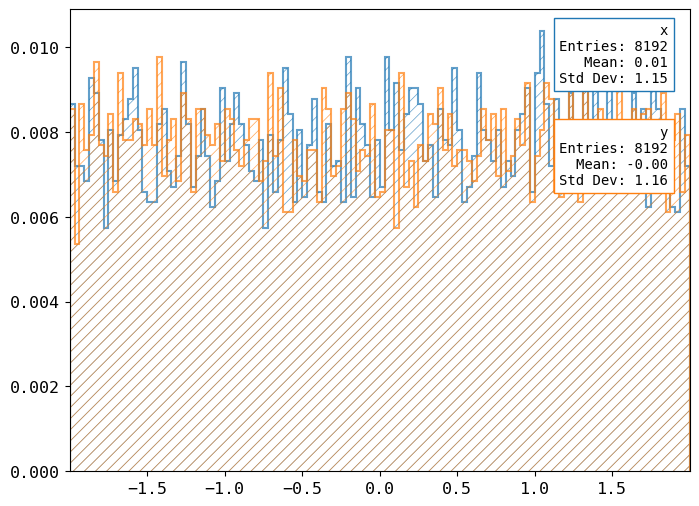

In [135]:
nfm = get_nfm(q0=a, hidden_units=128, linear_permute=False)
plot_proposal(a, n_samples=8192)
plot_proposal(nfm, n_samples=8192)

In [128]:
print(f'Uninitalized NF: {get_result(nfm, func)}')
print(f'Uniform dist   : {get_result(a, func, n_samples=10000)}')


# samples, log_p = nfm.sample(1000)
# results = func(samples).detach().cpu().numpy()

Uninitalized NF: (1.312637141381856e-05, 1.5321288628911134e-06)
Uniform dist   : (0.014446674846112728, 0.000538176333066076)


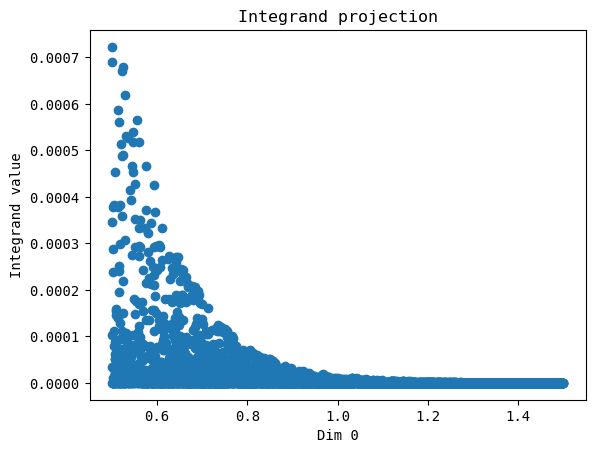

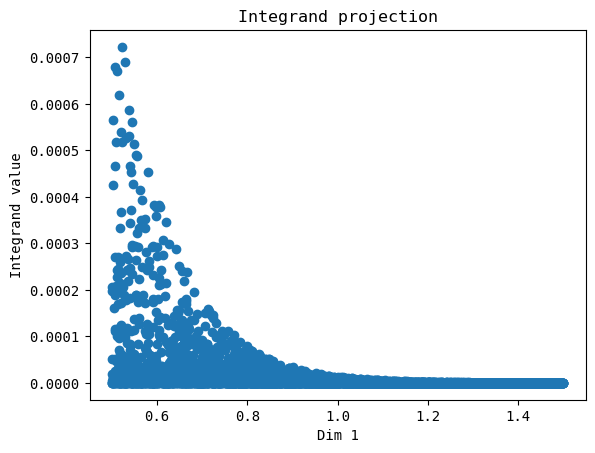

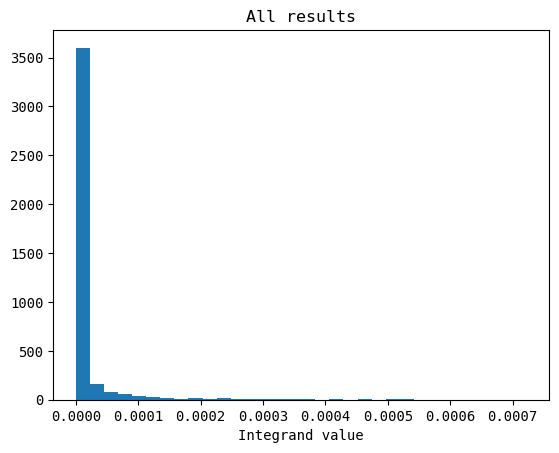

In [129]:
plot_integrand(nfm, func, n_samples=4096)

In [103]:
def train_iflow(nfm, func, n_samples:int=16384, n_epochs:int=10, lr:float=1e-4):
    optimizer = torch.optim.Adam(nfm.parameters(), lr=lr)
    for i in range(n_epochs):
        optimizer.zero_grad()
        
        z, logq = nfm.q0(n_samples)
        true = torch.abs(func(z)).detach()
        logp = torch.where(true > 1e-16, true.log(), true + 1e-16).detach()
        
        # Transform through NFlow
        for flow in nfm.flows:
            z, log_det = flow(z)
            logq -= log_det
        
        test = logq.exp().detach()
        
        mean = torch.mean(true/test)
        var = torch.var(true/test)
        
        true = true/mean
        loss = (1/n_samples) * ((true/test) * (logp - logq)**2).sum()
        
        loss.backward()
        optimizer.step()
        
        #if i % 10 == 0:
        print(f"Epoch {i}: {loss.item()} | Var {var}")
        
def train_backward(nfm, func, n_samples:int=32000, n_epochs:int=10):
    optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3)
    p = nfm.q0.log_prob_val.exp()
    
    for i in range(n_epochs):
        optimizer.zero_grad()
        samples, log_p = nfm.sample(n_samples)
        
        prob = log_p.exp()
        results = func(samples).detach()
        
        loss = (1/n_samples * (1/(p*prob)) * results**2).sum()
        loss.backward()
        optimizer.step()
        
        #if i % 10 == 0:
        print(f"Epoch {i}: {loss.item()}")

In [104]:
#train_forward(nfm, func, n_epochs=10)
train_iflow(nfm, func, n_epochs=25, n_samples=32000, lr=1e-3)

Epoch 0: 6.034485816955566 | Var 0.0036075469106435776
Epoch 1: 4.736032485961914 | Var 0.006357642821967602
Epoch 2: 3.606468915939331 | Var 0.011279987171292305
Epoch 3: 2.820814371109009 | Var 0.018157929182052612
Epoch 4: 2.0811896324157715 | Var 0.03374841436743736
Epoch 5: 1.7033655643463135 | Var 0.05230104178190231
Epoch 6: 1.4687751531600952 | Var 0.07351177930831909
Epoch 7: 1.3520619869232178 | Var 0.08307336270809174
Epoch 8: 1.25742769241333 | Var 0.07852776348590851
Epoch 9: 1.2484149932861328 | Var 0.06368184089660645
Epoch 10: 1.2276512384414673 | Var 0.05294157937169075
Epoch 11: 1.3347043991088867 | Var 0.04096943512558937
Epoch 12: 1.340812087059021 | Var 0.036298494786024094
Epoch 13: 1.4447617530822754 | Var 0.03036760352551937
Epoch 14: 1.4537134170532227 | Var 0.027599774301052094
Epoch 15: 1.490273118019104 | Var 0.026318391785025597
Epoch 16: 1.4305706024169922 | Var 0.02642083540558815
Epoch 17: 1.3453866243362427 | Var 0.027599139139056206
Epoch 18: 1.2970679

Using inferred bounds 5.9957956182188354e-06 to 1.0


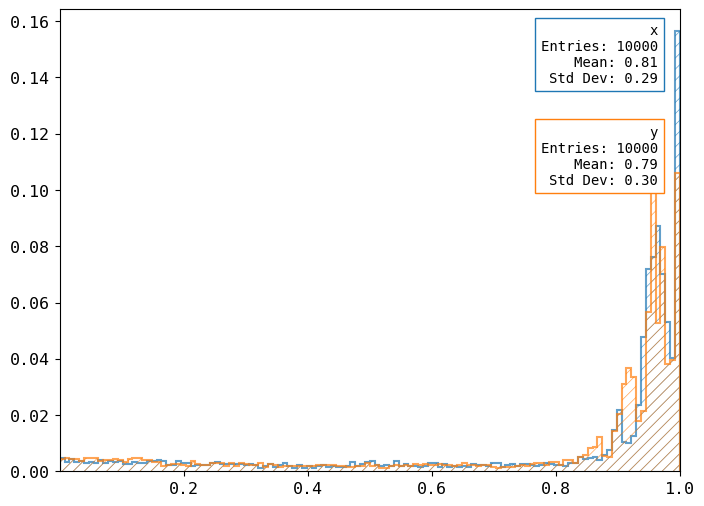

In [105]:
plot_proposal(nfm, n_samples=10000)

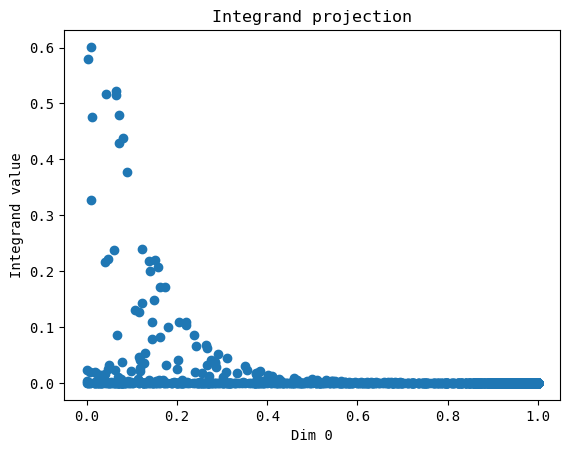

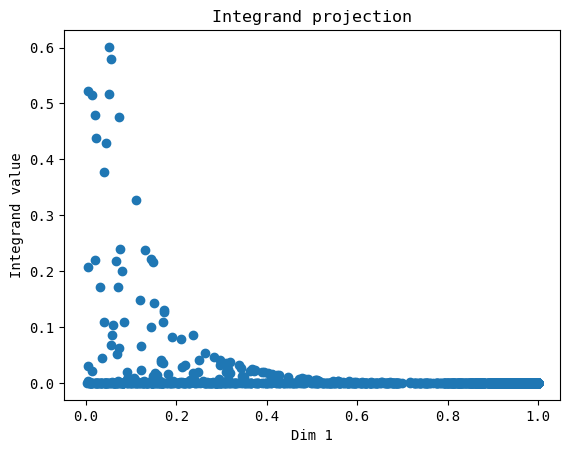

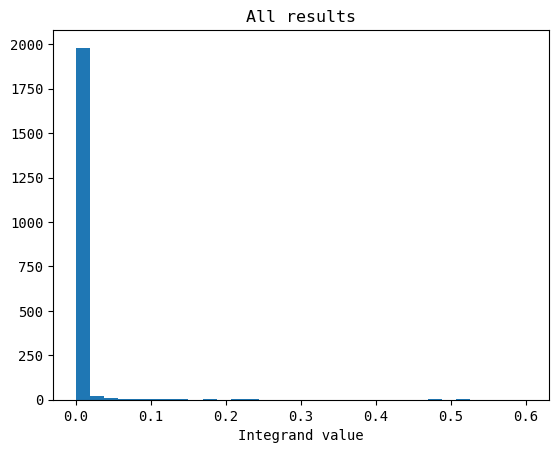

In [106]:
plot_integrand(nfm, func, y_log=False)

In [107]:
get_result(nfm, func, n_samples=4096)

(0.017688602209091187, 0.0015523942420259118)

In [61]:
n_samples = 100

samples, logq = nfm.sample(n_samples)
true = torch.abs(func(samples.detach()))
test = logq.exp()
mean = torch.mean(true/test)
var = torch.var(true/test)

print(mean, torch.sqrt(var/(n_samples-1.)).item())

tensor(0.0152, grad_fn=<MeanBackward0>) 0.007869748398661613
